In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv1D, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
from tqdm import tqdm
import time
import numpy as np

In [ ]:
# 保留label=1前26frames+labels=1時的data，並刪除原本的data
def load_gesture_data(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            print(f"Loading category: {category}")
            data_files = []
            label_files = []

            for filename in os.listdir(category_path):
                if filename.endswith('.npy') and 'data' in filename:
                    data_files.append(filename)
                if filename.endswith('.npy') and 'label' in filename:
                    label_files.append(filename)
            
            data_files.sort()
            label_files.sort()

            for i, (data_file, label_file) in enumerate(zip(data_files, label_files)):
                data_path = os.path.join(category_path, data_file)
                label_path = os.path.join(category_path, label_file)
                
                data = np.load(data_path)
                label = np.load(label_path)

                print(f"data_loaded: {data_file}")
                print(f"label_loaded: {label_file}")

                first_one_index = np.where(label.flatten() == 1)[0][0]

                start_index = max(0, first_one_index - 26)
                end_index = first_one_index

                pre_data = data[:, :, :, start_index:end_index]
                
                label_one_data = data[:, :, :, label.flatten() == 1]

                filtered_data = np.concatenate((pre_data, label_one_data), axis=-1)

                filtered_data_filename = f"{os.path.splitext(data_file)[0]}_filtered.npy"
                np.save(os.path.join(category_path, filtered_data_filename), filtered_data)
                print(f"Saved filtered data to {filtered_data_filename}")

                os.remove(data_path)
                print(f"Removed data: {data_path}")
                os.remove(label_path)
                print(f"Removed label: {label_path}")


In [ ]:
load_gesture_data('dataset')

In [ ]:
# 載入處理過後的資料集並切成每35一段並保存成segment npy
def load_gesture_data(directory):
    TimeSp = 35
    segment_counter = 0
    
    categories = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            categories.append(category)
    
    category_files = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        files = []
        for file in os.listdir(category_path):
            if file.endswith('.npy'):
                files.append(file)
        category_files[category] = files
    
    max_files = 0
    for files in category_files.values():
        if len(files) > max_files:
            max_files = len(files)
    
    for i in range(max_files):
        for category in categories:
            files = category_files[category]
            
            if i < len(files):
                file_name = files[i]
                file_path = os.path.join(category, file_name)
                file_path_full = os.path.join(directory, file_path)
                print(f"Loading {file_path_full}")
                data = np.load(file_path_full)
                for j in range(100000):
                    if j+TimeSp>=len(data[0,0,0]):
                        break
                    segment = data[:,:,:,j:j+TimeSp]
                    save_category_dir = os.path.join(directory, category)
                    segment_file_name = f"{category}_segment_{segment_counter}.npy"
                    segment_file_path = os.path.join(save_category_dir, segment_file_name)
                    print(f"Saving {segment_file_path}")
                    np.save(segment_file_path, segment)
                    segment_counter += 1 



In [ ]:
load_gesture_data('dataset')

In [ ]:
# 刪除data和label，保留segments
def load_and_delete_gesture_data(directory):
    
    categories = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            categories.append(category)
    
    category_files = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        files = []
        for file in os.listdir(category_path):
            if file.endswith('.npy') and 'data' in file:
                files.append(file)
        category_files[category] = files
    
    max_files = 0
    for files in category_files.values():
        if len(files) > max_files:
            max_files = len(files)
    
    for i in range(max_files):
        for category in categories:
            files = category_files[category]
            
            if i < len(files):
                file_name = files[i]
                file_path = os.path.join(directory, category, file_name)

                print(f"Removing {file_path}")
                os.remove(file_path)


In [ ]:
load_and_delete_gesture_data('train_data\\test')
load_and_delete_gesture_data('train_data\\train')
load_and_delete_gesture_data('train_data\\validation')

In [ ]:
# 找出最短的動作 小於35個考慮重錄
def load_gesture_data(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            print(f"Loading category: {category}")
            data_files = []
            label_files = []

            for filename in os.listdir(category_path):
                if filename.endswith('.npy') and 'data' in filename:
                    data_files.append(filename)
                if filename.endswith('.npy') and 'label' in filename:
                    label_files.append(filename)
            
            data_files.sort()
            label_files.sort()

            min_length = float('inf')
            min_length_file = None
            for data_file in data_files:
                data_path = os.path.join(category_path, data_file)
                data = np.load(data_path)
                data_length = data.shape[-1]
                if data_length < min_length:
                    min_length = data_length
                    min_length_file = data_file

            print(f"The smallest data length in category {category} is: {min_length}, file: {min_length_file}")

In [ ]:
load_gesture_data('dataset')

In [6]:
gesture_data_train, gesture_labels_train = load_gesture_data('train_data/train')
gesture_data_test, gesture_labels_test = load_gesture_data('train_data/test')
gesture_data_val, gesture_labels_val = load_gesture_data('train_data/validation')

Loading train_data/train\fall_down\fall_down_segment_0.npy
Loading train_data/train\patpat\patpat_segment_1029.npy
Loading train_data/train\quickDown\quickDown_segment_1045.npy
Loading train_data/train\quickUp\quickUp_segment_1053.npy
Loading train_data/train\rollin\rollin_segment_1073.npy
Loading train_data/train\rollout\rollout_segment_100.npy
Loading train_data/train\swipLeft\swipLeft_segment_102.npy
Loading train_data/train\swipRight\swipRight_segment_1000.npy
Loading train_data/train\fall_down\fall_down_segment_1.npy
Loading train_data/train\patpat\patpat_segment_1030.npy
Loading train_data/train\quickDown\quickDown_segment_1046.npy
Loading train_data/train\quickUp\quickUp_segment_1054.npy
Loading train_data/train\rollin\rollin_segment_1074.npy
Loading train_data/train\rollout\rollout_segment_101.npy
Loading train_data/train\swipLeft\swipLeft_segment_103.npy
Loading train_data/train\swipRight\swipRight_segment_1001.npy
Loading train_data/train\fall_down\fall_down_segment_10.npy
Lo

gesture_data reshape: (7255, 71680)
unique_labels: ['quickUp', 'rollout', 'swipRight', 'rollin', 'swipLeft', 'patpat', 'quickDown', 'fall_down']


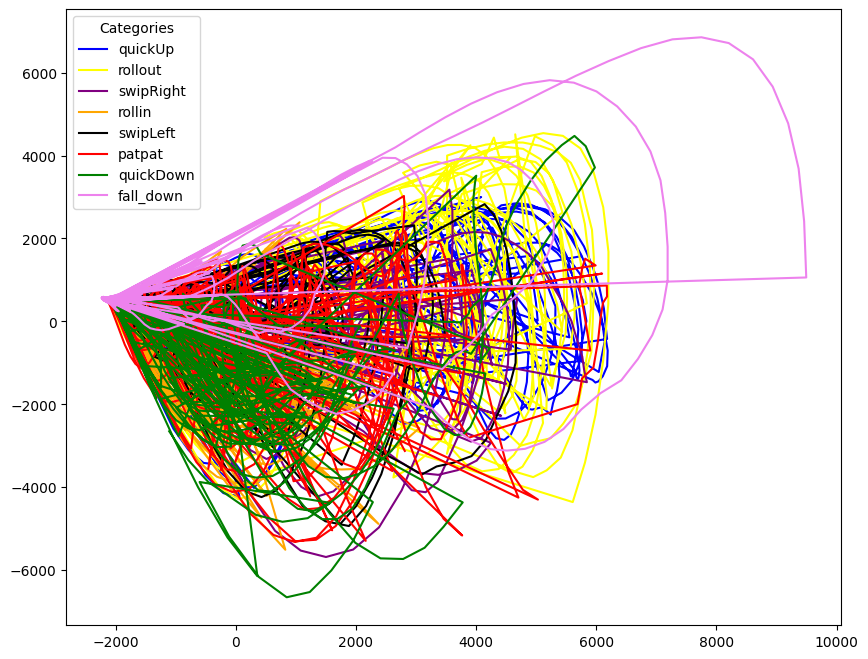

In [7]:
from sklearn import decomposition
import matplotlib.pyplot as plt
# 主元素分析圖

gesture_data=np.array(gesture_data_train).reshape([len(gesture_data_train),-1,35]).reshape([len(gesture_data_train),-1])

print("gesture_data reshape:", np.shape(gesture_data))

pca = decomposition.PCA(n_components=2)
pca.fit(gesture_data)
Dim2 = pca.transform(gesture_data)

labels = np.array(gesture_labels_train)
#print("labels", labels)

unique_labels = list(set(labels))
print("unique_labels:", unique_labels)

colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels))) # red(0) -> violet(1)

label_to_color = {}
for i in range(len(unique_labels)):
    label = unique_labels[i]
    label_to_color[label] = colors[i]

label_to_color = {
    'patpat': [1, 0, 0, 1],          # Red
    'quickDown': [0, 0.5, 0, 1],     # Green
    'quickUp': [0, 0, 1, 1],         # Blue
    'rollin': [1, 0.65, 0, 1],       # Orange
    'rollout': [1, 1, 0, 1],         # Yellow
    'swipLeft': [0, 0, 0, 1],        # Black
    'fall_down': [0.93, 0.51, 0.93, 1], # Violet
    'swipRight': [0.5, 0, 0.5, 1]    # Purple
}

# transparent
'''
label_to_color = {
    'patpat': [1, 0, 0, 0],        
    'quickDown': [0, 0.5, 0, 0],   
    'quickUp': [0, 0, 1, 0],         
    'rollin': [1, 0.65, 0, 0],   
    'rollout': [1, 1, 0, 0],  
    'swipLeft': [0, 0, 0, 0], 
    'fall_down': [0.93, 0.51, 0.93, 1], 
    'swipRight': [0.5, 0, 0.5, 0]    
}
'''

plt.figure(figsize=(10, 8))
for label in unique_labels:
    indices = labels == label
    #plt.scatter(Dim2[indices, 0], Dim2[indices, 1], label=label,color=label_to_color[label])
    plt.plot(Dim2[indices, 0], Dim2[indices, 1], label=label, color=label_to_color[label])
plt.legend(title='Categories', loc='best')